# Project 3 for CSE142
## CIFAR-10 Classification

Importing necessary packages:

- tensorflow/keras: API to build and train models
- matplotlib: generate graphs
- numpy: perform array operations
- pandas: to work with dataframes
- pickle: for serializing and de-serializing a Python object
- os: for file paths

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
# import pickle
# import os, os.path
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam

### *Initialize relevant variables*

In [3]:
labels_df = pd.read_csv("Semi1_Labels.csv") #change this for different versions
train_path = 'Train_Image' 
test_path = 'Test_Image' 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_df

,Train Label
0,NAN
1,dog
2,NAN
3,airplane
4,NAN
5,NAN
6,NAN
7,NAN
8,deer
9,NAN


## Defining some functions

In [4]:
def get_image(img_number):
    img = mpimg.imread(train_path + f"/{img_number}.png") 
    return img
def get_test_image(img_number):
    img = mpimg.imread(test_path + f"/{img_number}.png") 
    return img
def get_label(arr):
    max_index_col = np.argmax(arr, axis=0)
    return labels[max_index_col]

In [5]:
# plt.imshow(get_image(7777))

In [6]:
# plt.imshow(get_test_image(999))

**Function that prints image info**

In [7]:
def get_img_info(img):
    rows,cols,channels = img.shape 
    img_size = rows*cols*channels # channels means rgb colors i think, so should always be 3?
    img_to_1D = img.reshape(img_size) #numPy reshape
    print("rows, cols, channels:", rows, cols, channels)
    print("image size:", img_size)
#     print("image original:", img)
#     print("image reshape:", img_to_1D)
#     return img_to_1D

In [8]:
# get_img_info(get_image(3)) 

## Preprocessing the  Data

We need to separate the labeled data from the unlabeled

Also need to encode labels as numbers instead of strings

In [9]:
#is_unlabelled = labels_df["Train Label"] == NAN
labelled = (labels_df["Train Label"]!= "NAN")
unlabelled = (labels_df["Train Label"] == "NAN")

unlabelled_data = (labels_df[unlabelled])
print(unlabelled_data)

labelled_data = (labels_df[labelled])
print(labelled_data)

     Train Label
0            NAN
2            NAN
4            NAN
5            NAN
6            NAN
7            NAN
9            NAN
10           NAN
11           NAN
12           NAN
13           NAN
14           NAN
15           NAN
16           NAN
17           NAN
19           NAN
20           NAN
21           NAN
22           NAN
23           NAN
24           NAN
25           NAN
28           NAN
31           NAN
34           NAN
35           NAN
36           NAN
38           NAN
39           NAN
40           NAN
...          ...
9959         NAN
9960         NAN
9961         NAN
9962         NAN
9963         NAN
9966         NAN
9967         NAN
9968         NAN
9971         NAN
9972         NAN
9973         NAN
9975         NAN
9978         NAN
9979         NAN
9980         NAN
9981         NAN
9982         NAN
9983         NAN
9984         NAN
9985         NAN
9986         NAN
9987         NAN
9989         NAN
9991         NAN
9993         NAN
9994         NAN
9995         N

In [10]:
labeled = []
unlabeled = []

labeled = labelled_data["Train Label"].tolist()
unlabeled = unlabelled_data["Train Label"].tolist()

# print (labeled) 
# print (unlabeled) 

In [11]:
#col = labels_df.columns
#for i, entry in enumerate(labels_df[col[0]]):
 #   if (entry == 'NAN'):
  #      unlabeled.append(i)
   # else:
   #     labeled.append([i, entry])
# print("labeled", labeled)
# print("unlabeled", unlabeled)


2000


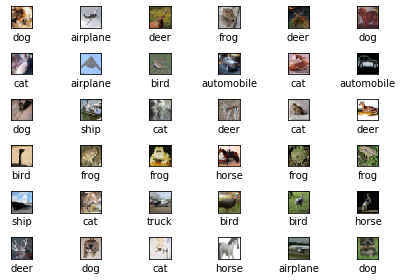

In [12]:
# Need to reshape training data and labels
train_images, train_labels, test_images, test_labels = [], [], [], []
for i in labelled_data.iterrows():
    train_images.append(get_image(i[0]))
    train_labels.append(i[1]['Train Label'])
print(len(train_images))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

In [13]:
print(train_labels)

['dog', 'airplane', 'deer', 'frog', 'deer', 'dog', 'cat', 'airplane', 'bird', 'automobile', 'cat', 'automobile', 'dog', 'ship', 'cat', 'deer', 'cat', 'deer', 'bird', 'frog', 'frog', 'horse', 'frog', 'frog', 'ship', 'cat', 'truck', 'bird', 'bird', 'horse', 'deer', 'dog', 'cat', 'horse', 'airplane', 'dog', 'truck', 'airplane', 'cat', 'frog', 'ship', 'horse', 'horse', 'truck', 'truck', 'airplane', 'truck', 'truck', 'cat', 'horse', 'frog', 'frog', 'deer', 'automobile', 'dog', 'dog', 'cat', 'horse', 'frog', 'automobile', 'deer', 'ship', 'dog', 'bird', 'airplane', 'horse', 'airplane', 'cat', 'airplane', 'automobile', 'deer', 'frog', 'ship', 'frog', 'ship', 'dog', 'horse', 'dog', 'horse', 'bird', 'airplane', 'dog', 'frog', 'automobile', 'automobile', 'truck', 'ship', 'frog', 'horse', 'frog', 'ship', 'deer', 'automobile', 'frog', 'automobile', 'deer', 'horse', 'cat', 'truck', 'horse', 'cat', 'automobile', 'bird', 'truck', 'truck', 'automobile', 'bird', 'airplane', 'automobile', 'frog', 'horse'

### TODO: One-Hot Encoding

In [ ]:
#USED FOLLOWING TUTORIAL: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/#:~:text=A%20one%20hot%20encoding%20allows,output%20variables%20that%20are%20categorical.

In [16]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

##One hot 
values = array(train_labels)
print(values)

[5 0 4 ... 1 2 0]


In [17]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values) 
print(integer_encoded)

[5 0 4 ... 1 2 0]


In [18]:
onehot_encoder = OneHotEncoder(sparse =False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [14]:
#change this to one-hot
for i in range(len(train_labels)):
    for j in range(len(labels)):
        if train_labels[i] == labels[j]:
            train_labels[i] = j
# print (train_labels)

In [13]:
#split labeled data so that we have some labeled testing data 80/20
test_images =  np.array(train_images[1600:])
train_images = np.array(train_images[:1600])
test_labels = np.array(train_labels[1600:])
train_labels = np.array(train_labels[:1600])
print(len(train_images), len(train_labels), len(test_images), len(test_labels))


1600 1600 400 400


## Baseline Model

### Convolutional Neural Network

As input, a CNN takes tensors of shape (height, width, channels) = (32, 32, 3)

This is based on https://www.tensorflow.org/tutorials/images/cnn

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [15]:
#Is this stopping too soon?
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=3, restore_best_weights=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 



In [16]:
history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback2])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 2s 1ms/sample - loss: 2.2550 - accuracy: 0.1600 - val_loss: 2.1120 - val_accuracy: 0.2150
Epoch 2/100
1600/1600 [==============================] - 1s 711us/sample - loss: 2.0486 - accuracy: 0.2450 - val_loss: 1.9863 - val_accuracy: 0.2450
Epoch 3/100
1600/1600 [==============================] - 1s 705us/sample - loss: 1.9091 - accuracy: 0.2969 - val_loss: 1.8438 - val_accuracy: 0.3150
Epoch 4/100
1600/1600 [==============================] - 1s 711us/sample - loss: 1.7840 - accuracy: 0.3644 - val_loss: 1.7973 - val_accuracy: 0.3225
Epoch 5/100
1600/1600 [==============================] - 1s 699us/sample - loss: 1.6524 - accuracy: 0.3969 - val_loss: 1.8027 - val_accuracy: 0.3525
Epoch 6/100
1600/1600 [==============================] - 1s 704us/sample - loss: 1.5864 - accuracy: 0.4331 - val_loss: 1.7276 - val_accuracy: 0.4200
Epoch 7/100
1600/1600 [==============================] - 1s 7

## Augmenting the Model



### Label some of our unlabeled data

In [17]:
new_labels = [];
new_images = [];

for j,i in enumerate(unlabelled_data.iterrows()):
    if j < 500:
        new_images.append(get_image(i[0]))
#         print(i[0])


predictions = model.predict(np.array(new_images))
for i in predictions:
    new_labels.append(get_label(i))
    
print(len(new_images), len(new_labels))

500 500


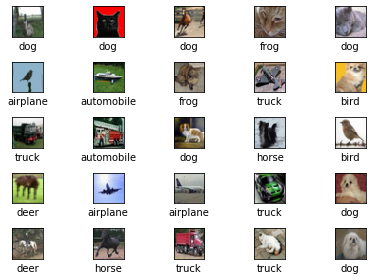

In [18]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(new_images[i])
    plt.xlabel(new_labels[i])
plt.show()

In [19]:
new_train_images = np.concatenate((train_images, new_images), axis=0)
new_train_labels = np.concatenate((train_labels, new_labels), axis=0)

for i in range(len(new_train_labels)):
    for j in range(len(labels)):
        if new_train_labels[i] == labels[j]:
            new_train_labels[i] = j
            
new_train_labels = tf.strings.to_number(new_train_labels)
            
print(len(new_train_images),len(new_train_labels))

print(new_train_labels, train_labels)


2100 2100
tf.Tensor([5. 0. 4. ... 4. 4. 4.], shape=(2100,), dtype=float32) [5 0 4 ... 7 3 0]


In [20]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10))
model2.summary()

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

history2 = model2.fit(new_train_images, new_train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## ResNet 50 

As per TA recommendation

## TODO: figure this out

In [21]:
# resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3), pooling='max')
resnet = ResNet50(include_top=False, input_shape=(128,128,3), pooling='max')

for layer in resnet.layers:
#     print(layer)
    layer.trainable = False

    
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
normal = tf.keras.layers.BatchNormalization()
dropout =tf.keras.layers.Dropout(0.4)
output = tf.keras.layers.Dense(10, activation='softmax')(resnet.output)


94773248/94765736 [==============================] - 7s 0us/step


In [22]:
res = tf.keras.models.Model(resnet.input, output)
res.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
augmented_model = tf.keras.models.Sequential()
augmented_model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu', input_shape=(32,32,3)))
augmented_model.add(tf.keras.layers.BatchNormalization())
augmented_model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu'))
augmented_model.add(tf.keras.layers.BatchNormalization())
augmented_model.add(res)

In [24]:
augmented_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 64, 64, 3)         84        
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 3)       84        
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
model (Model)                (None, 10)                23608202  
Total params: 23,608,394
Trainable params: 20,670
Non-trainable params: 23,587,724
_________________________________________________________________


In [25]:
augmented_model.compile(optimizer=Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = augmented_model.fit(train_images, train_labels, epochs=20, batch_size=32, verbose=1,
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 154s 96ms/sample - loss: 2.2972 - accuracy: 0.1531 - val_loss: 2.3063 - val_accuracy: 0.1175
Epoch 2/20
1600/1600 [==============================] - 149s 93ms/sample - loss: 2.2481 - accuracy: 0.2075 - val_loss: 2.3116 - val_accuracy: 0.1175
Epoch 3/20
1600/1600 [==============================] - 140s 88ms/sample - loss: 2.2217 - accuracy: 0.2344 - val_loss: 2.3109 - val_accuracy: 0.1175
Epoch 4/20
1600/1600 [==============================] - 147s 92ms/sample - loss: 2.2201 - accuracy: 0.2381 - val_loss: 2.3126 - val_accuracy: 0.1175
Epoch 5/20
1600/1600 [==============================] - 141s 88ms/sample - loss: 2.2177 - accuracy: 0.2406 - val_loss: 2.3133 - val_accuracy: 0.1175


In [26]:
augmented_model2 = tf.keras.models.Sequential()
augmented_model2.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu', input_shape=(32,32,3)))
augmented_model2.add(tf.keras.layers.BatchNormalization())
augmented_model2.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu'))
augmented_model2.add(tf.keras.layers.BatchNormalization())
augmented_model2.add(res)

augmented_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = augmented_model2.fit(new_train_images, new_train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Train on 2100 samples, validate on 400 samples
Epoch 1/100
2100/2100 [==============================] - 208s 99ms/sample - loss: 2.2572 - accuracy: 0.1957 - val_loss: 2.3110 - val_accuracy: 0.1175
Epoch 2/100
2100/2100 [==============================] - 201s 96ms/sample - loss: 2.1818 - accuracy: 0.2714 - val_loss: 2.3100 - val_accuracy: 0.1175
Epoch 3/100
2100/2100 [==============================] - 200s 95ms/sample - loss: 2.1848 - accuracy: 0.2714 - val_loss: 2.3095 - val_accuracy: 0.1175
Epoch 4/100
2100/2100 [==============================] - 200s 95ms/sample - loss: 2.1505 - accuracy: 0.3076 - val_loss: 2.3092 - val_accuracy: 0.1175
Epoch 5/100
2100/2100 [==============================] - 200s 95ms/sample - loss: 2.1414 - accuracy: 0.3162 - val_loss: 2.3104 - val_accuracy: 0.1175


# Predictions

Using our model and ResNet


## Write predictions to csv



In [27]:
import csv

f = open("submission.csv","w+")

pass